In [1]:
from xraycam.nbinit import *
camcontrol.set_detector('zwo')

Process Process-2:
Traceback (most recent call last):
  File "/home/xrayslaptippitytop/.local/lib/python3.5/site-packages/multiprocess-0.70.4-py3.5-linux-x86_64.egg/multiprocess/process.py", line 254, in _bootstrap
    self.run()
  File "/home/xrayslaptippitytop/.local/lib/python3.5/site-packages/multiprocess-0.70.4-py3.5-linux-x86_64.egg/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
zmq.error.ZMQError: Address already in use
  File "/home/xrayslaptippitytop/.local/lib/python3.5/site-packages/xraycam-0.0.0-py3.5.egg/xraycam/zwo.py", line 85, in sink_process
    zmq_comm.start_sink_routine(sink_function)
  File "/home/xrayslaptippitytop/.local/lib/python3.5/site-packages/xraycam-0.0.0-py3.5.egg/xraycam/zmq_comm.py", line 82, in start_sink_routine
    receiver.bind(sink_addr)
  File "zmq/backend/cython/socket.pyx", line 487, in zmq.backend.cython.socket.Socket.bind (zmq/backend/cython/socket.c:5156)
  File "zmq/backend/cython/checkrc.pxd", line 2

In [2]:
from xraycam.camalysis import fwhm
from scipy.ndimage.filters import gaussian_filter as gfilt
from scipy.interpolate import UnivariateSpline

In [3]:
def rebin_spectrum(x, y, rebin = 5):
    """
    Rebin `x` and `y` into arrays of length `int(len(x)/rebin)`. The
    highest-x bin is dropped in case len(x) isn't a multiple of rebin.
    x is assumed to be evenly-spaced and in ascending order.
    Returns: x, y
    """
    def group(arr1d, op = np.mean):
        """
        op: a function to evaluate on each new bin that returns a numeric value.
        >>> rebin = 3
        >>> group(range(10))
        [1.0, 4.0, 7.0]
        """
        import itertools
        i = itertools.count()
        def key(dummy):
            xindx = i.__next__()
            return int(xindx/rebin)
        return [op(list(values)) for groupnum, values in itertools.groupby(arr1d, key = key)][:-1]
    return group(x, np.mean), group(y, np.sum)

def energy_from_x_position(bragg,xpx,rebinparam=1,braggorder=1):
    """
    This function takes a bragg angle 'bragg', which is the bragg angle for a known
    energy on the camera, and takes an x position which is left (negative) or right (positive)
     of the central energy, in pixels 'xpx',
    and returns the energy of the x-ray which will be refocused to that position in the Rowland geometry.
    
    It is specific to Rowland diameter = 10cm, pixel size = 5.2 microns, and camera tangent to the circle.
    """
    pizel_size=2.9e-3 # NOTE: changed for new camera
    xpos=xpx*pizel_size*rebinparam
    return braggorder*1000*1.97705*np.sqrt(1+\
                           (xpos*np.cos(np.pi*bragg/90)+50*np.sin(np.pi*bragg/90))**2\
                           /(50-50*np.cos(np.pi*bragg/90)+xpos*np.sin(np.pi*bragg/90))**2)

def add_energy_scale(lineout,known_energy,known_bin=None,rebinparam=1,camerainvert=True,braggorder=1,**kwargs):
    """
    Returns an np array of [energies,lineout], by either applying a known energy to the max of the dataset, or to a specified bin.
    """
    if known_bin == None:
        centerindex=np.argmax(gfilt(lineout,3)) # if known_bin not provided, set energy to max of lineout
        # note to self, I was worried that gfilt might change the length of the list, but it doesn't.
    else:
        centerindex=round(known_bin/rebinparam) # else set energy to be at known bin position
    indexfromcenter=np.array(range(len(lineout)))-centerindex
    if camerainvert == True:
            indexfromcenter=-indexfromcenter # if camera gets flipped upside down, just reverse the indices
    return (energy_from_x_position(calc_bragg_angle(known_energy,braggorder),indexfromcenter,rebinparam,braggorder),lineout)
    
def calc_bragg_angle(energy,braggorder=1):
    """
    calculates bragg angle from energy given in eV.  Currently specific to si111 2d spacing.
    """
    si111_2dspacing=6.27118
    return 180*np.arcsin(12398.4*braggorder/(si111_2dspacing*energy))/np.pi
    
def plot_with_energy_scale(datarun,known_energy,yrange=[0,-1],xrange=[0,-1],rebin=1,show=True,peaknormalize=False,
                           label=None,calcfwhm=False,**kwargs):
    lineout = np.sum(datarun.get_array()[yrange[0]:yrange[1],xrange[0]:xrange[1]],axis=1)/datarun.photon_value
    if rebin != 1: #rebin using oliver's rebin_spectrum function
        lineout = rebin_spectrum(np.array(range(len(lineout))),lineout,rebin)[1]
    if peaknormalize == True:
        lineout = lineout / max(lineout)
    lineout_energyscale=add_energy_scale(lineout,known_energy,rebinparam=rebin,**kwargs)
    if label == None and calcfwhm == False:
        label=datarun.prefix
    elif label == None and calcfwhm == True:
        s=' - '
        label=s.join((str(datarun.prefix),str(fwhm_ev(lineout_energyscale,3))))
    elif label != None and calcfwhm == True:
        s=' - '
        label=s.join((label,str(fwhm_ev(lineout_energyscale))))
    plt.plot(*lineout_energyscale,label=label)
    if show == True:
        plt.show()

def fwhm_ev(arr2d,fwhm_smooth=2):
    """
    Given a 2d-array of [energies(eV),lineout], calculate fwhm of peak in the lineout.
    """
    x, y = arr2d
    y = gfilt(y,fwhm_smooth)
    spline = UnivariateSpline(x, y - np.max(y)/2, s = 0)
    r1, r2 = spline.roots()
    return format(r2 - r1, '.3f')

def fwhm_datarun(datarun,known_energy,yrange=[0,-1],xrange=[0,-1],rebin=1,fwhm_smooth=2,**kwargs):
    """
    Given a 2d-array of [energies(eV),lineout], calculate fwhm of peak in the lineout.
    """
    lineout = np.sum(datarun.get_array()[yrange[0]:yrange[1],xrange[0]:xrange[1]],axis=1)/datarun.photon_value
    if rebin != 1: #rebin using oliver's rebin_spectrum function
        lineout = rebin_spectrum(np.array(range(len(lineout))),lineout,rebin)[1]
    lineout_energyscale=add_energy_scale(lineout,known_energy,rebinparam=rebin,**kwargs)
    x, y = lineout_energyscale
    y = gfilt(y,fwhm_smooth)
    spline = UnivariateSpline(x, y - np.max(y)/2, s = 0)
    r1, r2 = spline.roots()
    return format(r2 - r1, '.3f')

def focus_ZvsFWHM_plot(dataruntuple,known_energy,**kwargs):
    plt.plot(*list(zip(*[(x.run.z,fwhm_datarun(x.run,known_energy,**kwargs)) for x in 
                     dataruntuple])),label='fwhm v z')
    plt.show()
    
def cropping_tool(datarun,step,known_energy=2014,calcfwhm=True,**kwargs):
    [plot_with_energy_scale(datarun.run,known_energy,label='['+','.join((str(i),str(i+step)))+']',xrange=[i,i+step],
                            show=False,calcfwhm=calcfwhm,peaknormalize=True,**kwargs) for i in range(0,2000,step)]
    plt.show()
    
class Monitor:
    def __init__(self, *args, transpose = True, vmax = 150, rebin = 1, **kwargs):
        self.run = camcontrol.DataRun(*args, **kwargs)
        self.vmax = vmax
        self.rebin = rebin

    def frame(self):
        return self.run.get_frame()
    
    def update(self):
        self.run.show(vmax = self.vmax)
        self.run.plot_lineout(rebin = self.rebin)
        self.frame().plot_histogram(xmin = 0, xmax = self.vmax)
        
    def stop(self):
        self.run.stop()

In [4]:
def center_of_masses(arr2d):
    def _cm(arr1d):
        return np.dot(arr1d, np.arange(len(arr1d)))/np.sum(arr1d)
    return np.array(list(map(_cm, arr2d)))

def cmplot(datarun, smooth=0):
    arr2d = np.transpose(datarun.run.get_array())
    y = center_of_masses(arr2d)
    x = np.arange(len(y))
    if smooth != 0:
        y = gfilt(y,smooth)
    plt.plot(x, y, label = 'CM lineout')
    plt.show()

In [5]:
def fwhm_vs_row_plot(datarun,step=100):
    plt.plot(*list(zip(*[(i+step/2,fwhm_datarun(datarun.run,2300,xrange=[i,i+step],rebin=2)) for i in range(0,2000,step)])),label='fwhm v row')
    plt.show()

# Shielding seems to have blocked noise on right side, back to focusing

In [7]:
focus0 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'focus0.contd.9.15',htime='10m')
focus0.run.theta=145
focus0.run.z=0

Loaded from cache.


In [8]:
focus1 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'focus1.contd.9.15',htime='10m')
focus1.run.theta=145
focus1.run.z=0.5

Loaded from cache.


In [9]:
focus2 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'focus2.contd.9.15',htime='10m')
focus2.run.theta=145
focus2.run.z=1

Loaded from cache.


In [10]:
focus3 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'focus3.contd.9.15',htime='10m')
focus3.run.theta=145
focus3.run.z=-0.5

Loaded from cache.


<IPython.core.display.Javascript object>


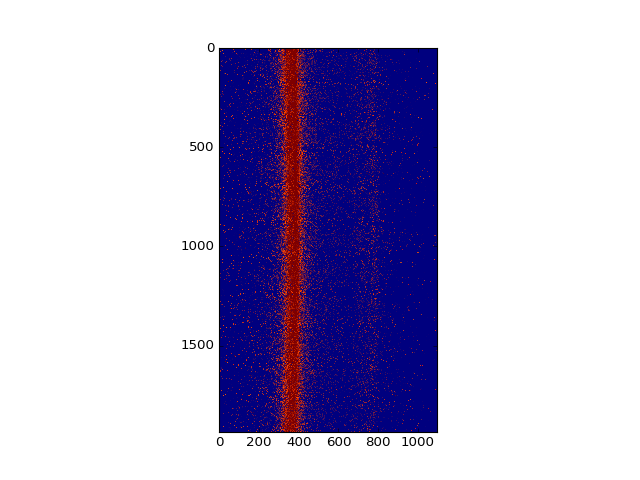

In [8]:
focus0.update()

In [57]:
cropping_tool(focus2,200,2300,rebin=1)

<IPython.core.display.Javascript object>


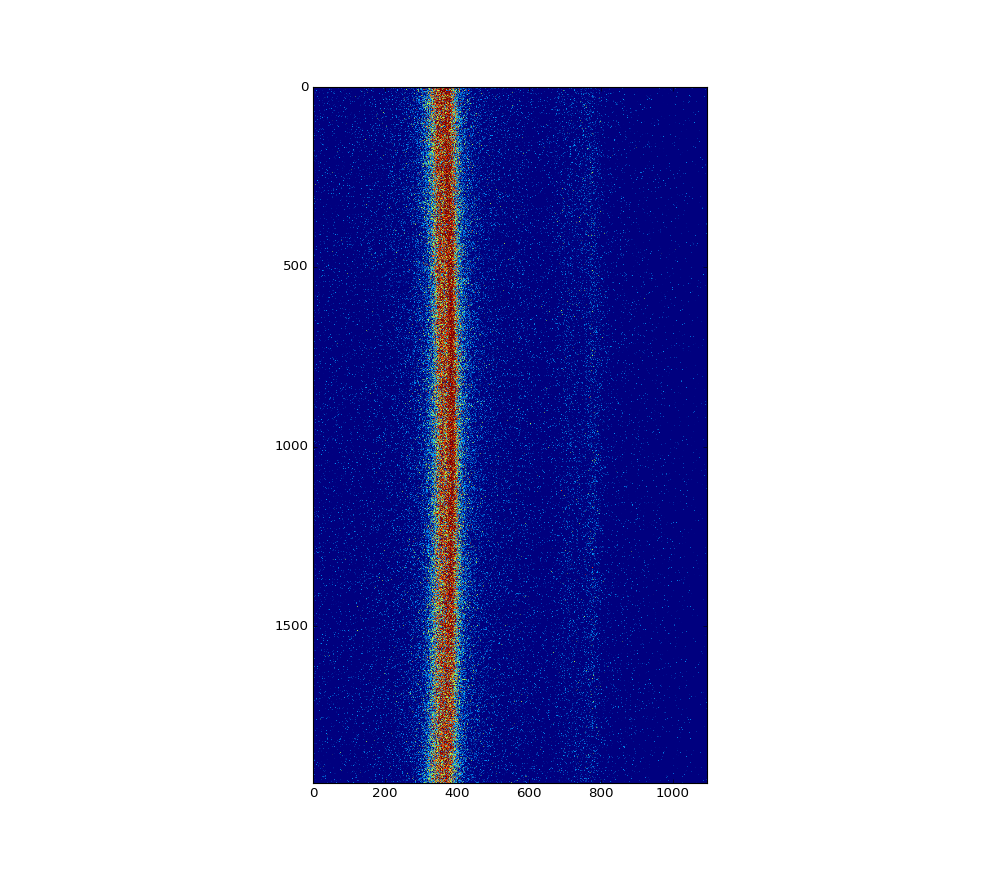

In [9]:
focus0.run.show(vmax=450)

In [84]:
[plot_with_energy_scale(x.run,2300,known_bin=300,label='ZnS - 135deg',rebin=1,
                           xrange=[800,1400],show=False,calcfwhm=True,peaknormalize=False)
 for x in (focus0,focus1,focus2,focus3)]
plt.show()

In [62]:
fwhm_vs_row_plot(focus2,step=200)

In [45]:
cmplot(np.transpose(focus1.run.get_array()),smooth=10)

<IPython.core.display.Javascript object>


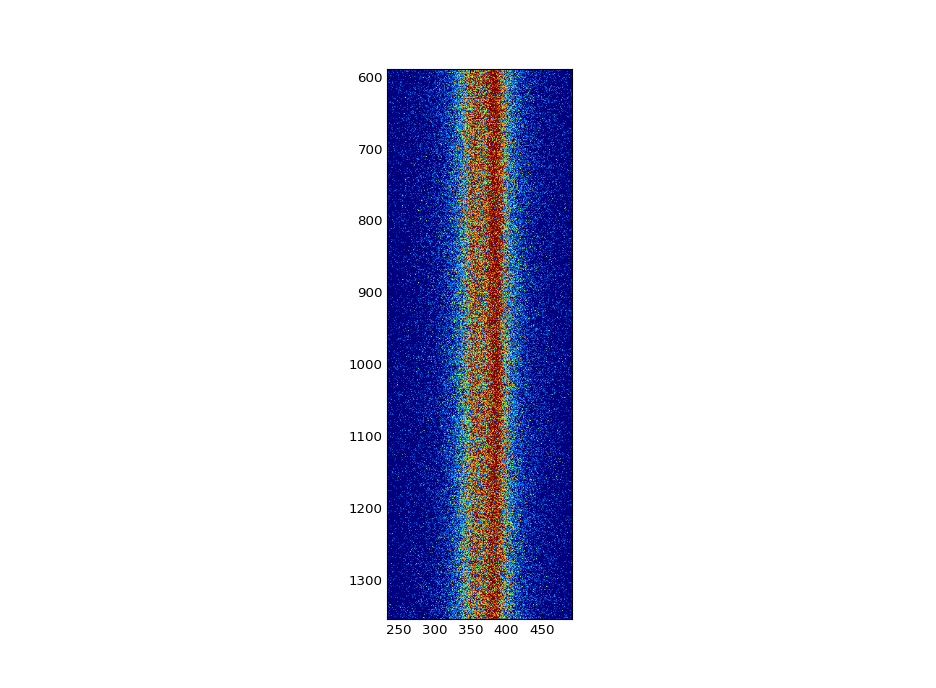

In [23]:
focus0.run.show(vmax=500)

In [81]:
focus3.run.acquisition_time()

576.3978493213654

stopped acquisistion


In [80]:
[x.run.counts_per_second() for x in (focus0,focus1,focus2,focus3)]

[940.67345461699949,
 928.44379466185353,
 917.54457966142911,
 938.92235677125257]

### Best focus at focus1

# Now optimize angle for CdS

In [6]:
cdsangle1 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'cdsangle1.contd.9.15',htime='1m')
cdsangle1.run.theta=325

starting acquisition


In [15]:
cdsangle2 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'cdsangle2.contd.9.15',htime='1m')
cdsangle2.run.theta=320

starting acquisition


In [26]:
cdsangle3 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'cdsangle3.contd.9.15',htime='1m')
cdsangle3.run.theta=315

starting acquisition


In [32]:
cdsangle4 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'cdsangle4.contd.9.15',htime='1m')
cdsangle4.run.theta=310

starting acquisition


In [39]:
cdsangle5 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'cdsangle5.contd.9.15',htime='1m')
cdsangle5.run.theta=330

starting acquisition


In [44]:
cdsangle6 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'cdsangle6.contd.9.15',htime='1m')
cdsangle6.run.theta=335

starting acquisition


In [48]:
cdsangle7 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'cdsangle7.contd.9.15',htime='1m')
cdsangle7.run.theta=340

starting acquisition


In [51]:
cdsangle8 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'cdsangle8.contd.9.15',htime='1m')
cdsangle8.run.theta=345

starting acquisition


In [42]:
[plot_with_energy_scale(x.run,2300,known_bin=300,label='ZnS - 135deg',rebin=3,
                           xrange=[800,1400],show=False,calcfwhm=True,peaknormalize=True)
 for x in (focus1,cdsangle1,cdsangle2,cdsangle3,cdsangle4,cdsangle5)]
plt.show()

stopped acquisistion


In [52]:
[x.run.counts_per_second() for x in (cdsangle8,cdsangle7,cdsangle6,cdsangle5,cdsangle1,cdsangle2,cdsangle3,cdsangle4)]

[40.292142436498921,
 98.949558210867792,
 137.89188132508016,
 117.15802281093991,
 82.921242149365042,
 68.181401510127984,
 70.722089463059788,
 70.783106703568251]

stopped acquisistion


In [53]:
cdsangle8.run.acquisition_time()

60.16091561317444

In [18]:
focus1.run.counts_per_second()

928.44379466185353

<IPython.core.display.Javascript object>


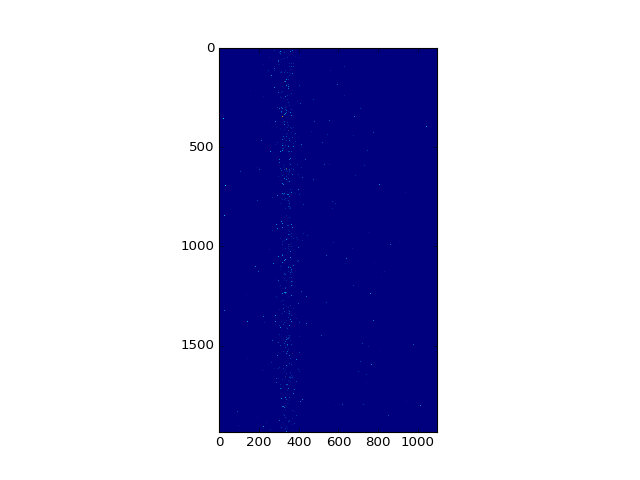

In [38]:
cdsangle4.run.show()

# Best angle is 335deg

In [11]:
cds0 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'cds0.contd.9.15')

Loaded from cache.


215 seconds into the exposure, I realized I should have gone to full power,
and switched to 25kV @ 2mA

<IPython.core.display.Javascript object>


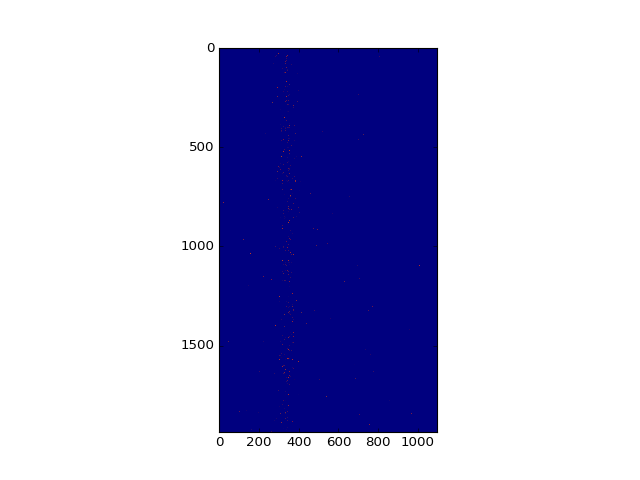

In [55]:
cds0.update()

In [116]:
cds0.run.counts_per_second()

187.030536964921

In [154]:
cds0.run.acquisition_time()

3601.148989200592

In [152]:
cds0.stop()

In [73]:
[plot_with_energy_scale(x.run,2300,known_bin=None,label='ZnS - 135deg',rebin=1,
                           xrange=[800,1400],show=False,calcfwhm=True,peaknormalize=True)
 for x in (focus1,cds0)]
plt.show()

In [141]:
plot_with_energy_scale(focus1.run,2300,known_bin=None,label='ZnS - 145deg',rebin=1,
                           xrange=[800,1400],show=False,calcfwhm=True,peaknormalize=True)
plot_with_energy_scale(cds0.run,2300,known_bin=None,label='CdS - 335deg',rebin=1,
                           xrange=[400,1200],show=False,calcfwhm=True,peaknormalize=True)
plot_with_energy_scale(cds0.run,2300,known_bin=None,label='CdS - crop2',rebin=1,
                           xrange=[600,1200],show=False,calcfwhm=True,peaknormalize=True)
plt.show()

<IPython.core.display.Javascript object>


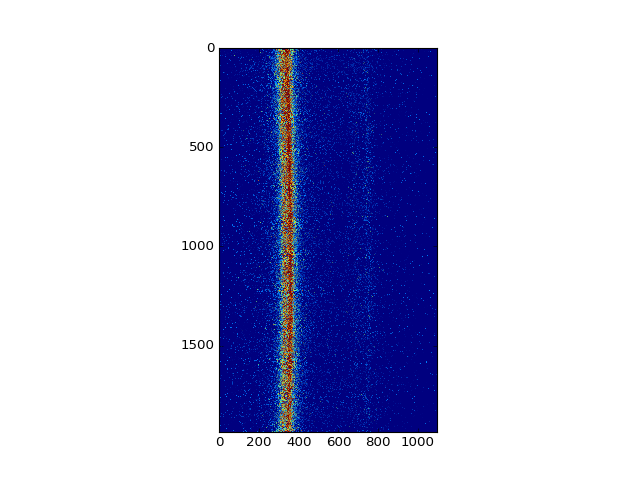

In [134]:
cds0.run.show(vmax=500)

In [143]:
cropping_tool(cds0,200,2300,rebin=1)

In [142]:
cmplot(cds0,smooth=10)

# Now take good ZnS data for comparison
* full power, 25kV @ 2mA
* gain 213, exposure 50ms

In [6]:
zns0 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'zns0.contd.9.15')

Loaded from cache.


<IPython.core.display.Javascript object>


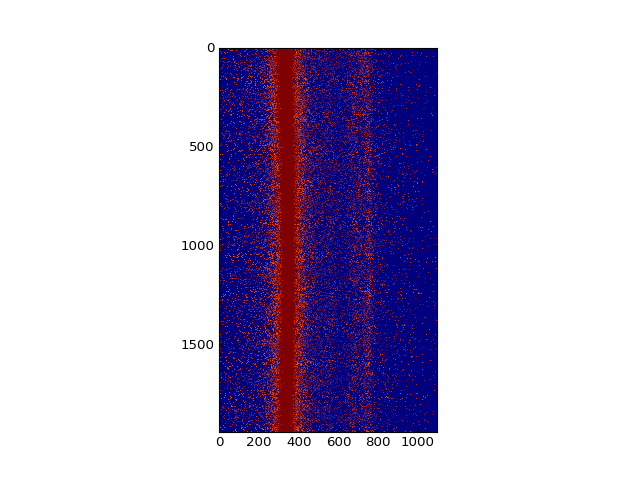

In [7]:
zns0.update()

In [10]:
plot_with_energy_scale(zns0.run,2307.69,known_bin=356,label='ZnS - 145deg',rebin=1,
                           xrange=[1000,1400],show=False,calcfwhm=True,peaknormalize=True)
#plot_with_energy_scale(cds0.run,2307.69,known_bin=356,label='CdS - 335deg',rebin=1,
#                           xrange=[400,1200],show=False,calcfwhm=True,peaknormalize=True)
plt.show()

In [214]:
cds0.run.acquisition_time()

3601.148989200592

In [201]:
cropping_tool(zns0,200,2300,rebin=1)

In [170]:
zns0.run.counts_per_second()

1245.4502761890571

In [206]:
zns0.run.acquisition_time()

1289.450432062149

In [207]:
zns0.stop()

# Now move back to CdS to confirm reproducibility

In [9]:
cdsreproducibility0 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'cdsreproducibility0.contd.9.15')

Loaded from cache.


In [255]:
plot_with_energy_scale(zns0.run,2307.69,known_bin=356,label='ZnS - 145deg',rebin=1,
                           xrange=[1000,1400],show=False,calcfwhm=True,peaknormalize=True)
plot_with_energy_scale(cds0.run,2307.69,known_bin=356,label='CdS - 335deg',rebin=1,
                           xrange=[400,1200],show=False,calcfwhm=True,peaknormalize=True)
plot_with_energy_scale(cdsreproducibility0.run,2307.69,known_bin=356,label='CdS - reprod',rebin=1,
                           xrange=[500,1400],show=False,calcfwhm=True,peaknormalize=True)
plt.show()

In [242]:
cdsreproducibility0.run.counts_per_second()

190.0410548137119

In [251]:
cdsreproducibility0.run.acquisition_time()

1207.2947373390198

In [252]:
cdsreproducibility0.stop()

# And back to ZnS for more reproducibility

In [8]:
znsreproducibility0 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'znsreproducibility0.contd.9.15')

Loaded from cache.


In [257]:
znsreproducibility0.run.counts_per_second()

1221.7616776794296

In [270]:
znsreproducibility0.run.acquisition_time()

336.7978239059448

In [265]:
znsreproducibility0.stop()

# Check CdS reproducibility again

In [6]:
cdsreproducibility1 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'cdsreproducibility1.contd.9.15')

In [21]:
znsreproducibility1 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'znsreproducibility1.contd.9.15')

In [22]:
znsreproducibility1.run.counts_per_second()

1238.1428970391682

In [27]:
plot_with_energy_scale(zns0.run,2307.69,known_bin=356,label='ZnS - 145deg',rebin=1,
                           xrange=[1000,1400],show=False,calcfwhm=True,peaknormalize=True)
plot_with_energy_scale(cds0.run,2307.69,known_bin=356,label='CdS - 335deg',rebin=1,
                           xrange=[400,1200],show=False,calcfwhm=True,peaknormalize=True)
plot_with_energy_scale(cdsreproducibility0.run,2307.69,known_bin=356,label='CdS - reprod',rebin=1,
                           xrange=[500,1400],show=False,calcfwhm=True,peaknormalize=True)
plot_with_energy_scale(znsreproducibility0.run,2307.69,known_bin=356,label='ZnS - reprod',rebin=1,
                           xrange=[1000,1400],show=False,calcfwhm=True,peaknormalize=True)
plot_with_energy_scale(cdsreproducibility1.run,2307.69,known_bin=356,label='Cds - reprod2',rebin=2,
                           xrange=[400,1400],show=False,calcfwhm=True,peaknormalize=True)
plot_with_energy_scale(znsreproducibility1.run,2307.69,known_bin=356,label='ZnS - reprod',rebin=1,
                           xrange=[1000,1400],show=False,calcfwhm=True,peaknormalize=True)
plt.show()

<IPython.core.display.Javascript object>


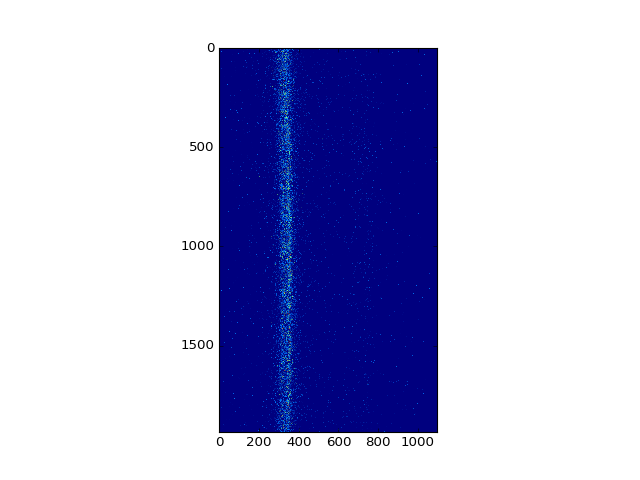

In [15]:
cdsreproducibility1.run.show(vmax=500)

In [26]:
cropping_tool(cdsreproducibility1,200,2300,rebin=2)

In [20]:
cdsreproducibility1.stop()

In [25]:
znsreproducibility1.stop()

<IPython.core.display.Javascript object>


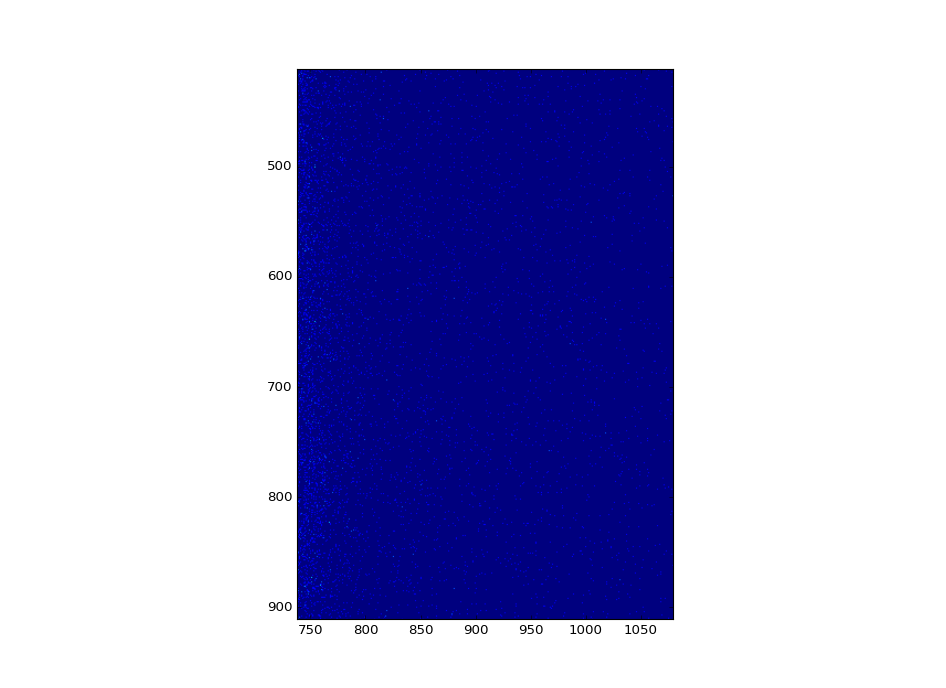

In [31]:
cds0.run.show(vmax=1200)